# Simple Neural Network - XOR

## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial2

Initializers
* `torch.zeros`: Creates a tensor filled with zeros
* `torch.ones`: Creates a tensor filled with ones
* `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$
* `torch.tensor` (input list): Creates a tensor from the list elements you provide

In [12]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_55401/47578708.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [30]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print("Device", device)
# torch.cuda.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Device", device)
torch.mps.manual_seed(42)

Device mps


In [15]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [17]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [44]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.reshape(-1,)
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [40]:
def eval_model(model, data_loader):
    model.eval() 
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): 
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            pred_labels = (torch.sigmoid(preds) > 0.5).int().reshape(-1)
            true_preds += (pred_labels == data_labels).sum().float()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [46]:
torch.manual_seed(42)
loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model(model, optimizer, train_data_loader, loss_module)

# Save model
state_dict = model.state_dict()
print(state_dict)
# torch.save(state_dict, "our_model.tar")
# state_dict = torch.load("our_model.tar")
# new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# new_model.load_state_dict(state_dict)

eval_model(model, test_data_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict({'linear1.weight': tensor([[ 2.2640,  2.4605],
        [-0.9237,  0.4053],
        [ 0.4808,  0.3007],
        [ 3.4268,  3.2572]], device='mps:0'), 'linear1.bias': tensor([-3.4984, -0.9601,  0.2648, -1.5697], device='mps:0'), 'linear2.weight': tensor([[-4.5774,  1.5608, -1.2563,  5.0034]], device='mps:0'), 'linear2.bias': tensor([-2.4380], device='mps:0')})
Accuracy of the model: 100.00%


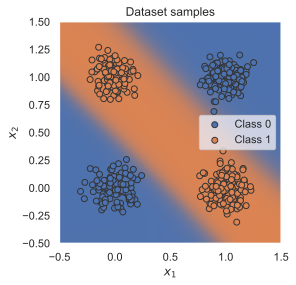

In [48]:
@torch.no_grad() # Decorator
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, test_dataset.data, test_dataset.label)
plt.show()